In [277]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from scipy.special import comb
from scipy.special import lambertw
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from scipy.interpolate import griddata, LinearNDInterpolator

# Define constants
L = 100
S_l = 1e3
d_t = 6
zeta = 2.5e3
tau = 1e4
omega = 25
kappa = 20
beta = 0.5  # Assuming beta = 0.5 as a typical value

def eta_l(l):
    """Compute eta_l based on skill level l."""
    return np.exp(7 * l / L)

def sigma_l(l):
    """Compute sigma_l based on skill level l."""
    return np.log2(l) if l > 1 else 0

def D_KL(p, q):
    """Compute KL divergence D_KL(p||q)."""
    return p * np.log(p/q) + (1-p) * np.log((1-p)/(1-q))

def g_function(R, p_rr, eta):
    """Compute g(R, p_rr, eta_l)."""
    R_choose_2 = comb(R, 2)
    # Ensure eta/R_choose_2 is within [0,1]
    eta_ratio = eta/R_choose_2
    # Ensure p_rr is within (0,1)
    p_rr_safe = p_rr
    
    return np.exp(-R_choose_2 * D_KL(eta_ratio, p_rr_safe))

def compute_p_rr(R, T, d_t):
    """Compute p_rr for a given R, T and d_t."""
    # Approximately (d_t/R)**2)*T / (S_l**2)
    return (1 - (1 - (d_t/R)**2)**T) / (S_l**2)

def compute_T(R):
    """Compute T based on R using the relationship T = (kappa * zeta) / tau * R."""
    return ((kappa * zeta) / tau) * R

def compute_p_l(R, p_rr, eta, gamma_prev, sigma):
    """Compute p_l based on the piecewise function."""
    R_choose_2 = comb(R, 2)
    
    if eta <= R_choose_2 * p_rr:
        return min(1, (1 - g_function(R, p_rr, eta)) * (gamma_prev**(2*sigma)) )
    else:
        g_val = g_function(R, p_rr, eta)
        #denominator = np.sqrt(8 * (eta) * (1 - eta/R_choose_2))
        denominator = np.sqrt(2*R_choose_2)
        return min(1, (g_val / denominator) * (gamma_prev**(2*sigma)) )


def compute_gamma_l(p_l):
    """Compute gamma_l using the Lambert W function."""
    z = -p_l * S_l * np.exp(-p_l * S_l)
    w_val = np.real(lambertw(z, k=0))
    gamma_l = 1 + (1 / (p_l * S_l)) * w_val
    # If gamma_l is nan, set it to 0
    if np.isnan(gamma_l):
        gamma_l = 0
    return gamma_l

def compute_recursive_values(R, l_max=100):
    """Compute p_l and gamma_l recursively for all levels up to l_max."""
    # Initialize with base conditions
    gamma_values = [1.0]  # gamma_0 = 1
    p_values = [0.0]      # placeholder for p_0 (not used)
    
    # Calculate T based on R
    T = compute_T(R)
    
    # Calculate p_rr
    p_rr = compute_p_rr(R, T, d_t)
    
    # Recursively compute p_l and gamma_l for each level
    for l in range(1, l_max + 1):
        gamma_prev = gamma_values[l-1]
        sigma = sigma_l(l)
        eta = eta_l(l)
        
        p_l = compute_p_l(R, p_rr, eta, gamma_prev, sigma)
        p_values.append(p_l)
        
        gamma_l = compute_gamma_l(p_l)
        gamma_values.append(gamma_l)
    
    return p_values, gamma_values

def compute_m_l_prime(l, l_prime, m):
    """Compute m_l' based on the given formula."""
    if l_prime > l:
        # Calculate the product term in the denominator
        prod = 1
        for k in range(l+1, l_prime+1):
            prod *= max(sigma_l(k), 1e-10)  # Avoid division by zero
        result = max(np.ceil(m / prod), 2)
    elif l_prime == l:
        result = m
    else:  # l_prime < l
        # Calculate the product term
        prod = 1
        for k in range(l_prime+1, l+1):
            prod *= max(sigma_l(k), 1e-10)  # Avoid division by zero
        result = np.ceil( m * prod )
    
    return result

def compute_M_l_prime(m_l_prime):
    """Compute M_l' based on m_l'."""
    return np.ceil(m_l_prime) + np.ceil(beta * m_l_prime)

def compute_training_cost(R):
    """Compute the training cost C_tr."""
    return 6 * kappa * zeta**2 * R**2

def compute_inference_cost(R, l_star, m_l_star, p_l_star):
    """Compute the inference cost C_inf."""
    M_l_star = compute_M_l_prime(m_l_star)
    
    # Avoid log(negative) issues
    product = p_l_star * M_l_star
    if product <= 1:
        return np.inf
    
    path_length = np.log(M_l_star) / np.log(product)
    return 2 * zeta * R * omega * m_l_star * path_length

def compute_accuracy(gamma_l_star, m_l_star):
    """Compute the accuracy for a given gamma_l_star and m_l_star."""
    return gamma_l_star ** m_l_star

def evaluate_allocation(C_tr, C_inf, l, m):
    """Evaluate accuracy for a given allocation of C_tr and C_inf."""
    # Calculate R from C_tr
    R = np.sqrt(C_tr / (6 * kappa * zeta**2))
    
    # Find best l_star for this allocation
    best_accuracy = 0
    
    # Compute recursive values
    p_values, gamma_values = compute_recursive_values(R, l_max=L)
    
    # Try different l_star values
    for l_star in range(1, L+1):
        p_l_star = p_values[l_star]
        gamma_l_star = gamma_values[l_star]
        m_l_star = compute_m_l_prime(l, l_star, m)
        
        # Check if inference cost is within budget
        C_inf_actual = compute_inference_cost(R, l_star, m_l_star, p_l_star)
        if C_inf_actual <= C_inf:
            # Calculate accuracy
            accuracy = compute_accuracy(gamma_l_star, m_l_star)
            best_accuracy = max(best_accuracy, accuracy)
    return best_accuracy

# Define distribution over l and m for task
def q(l,m):
    # Let q_l be (L choose l) (1/2)^L
    #q_l = comb(L, l) * (1/2)**L
    #if l==1: # Give l=1 the probability of l=0 plus l=1 (since l=0 is not a valid skill level)
    #    q_l += (1/2)**L
    # Have q_l be uniform from 1 to 100
    if l < 1 or l > 100:
        return 0
    q_l = 1/100
    
    # Let q_m be uniform from 2 to 10
    if m < 2 or m > 10:
        return 0
    q_m = 1/9
    return q_l * q_m

In [262]:
# Evaluate accuracy for all possible values of l and m for a given C_tr and C_inf
def evaluate_allocation_all(C_tr, C_inf):
    # Initialize accuracy matrix
    expected_accuracy = 0
    
    # Iterate over all possible values of l and m
    for l in range(1, L+1):
        for m in range(2, 11):
            expected_accuracy += evaluate_allocation(C_tr, C_inf, l, m) * q(l, m)
    
    return expected_accuracy

# Define the range of C_tr and C_inf values to evaluate
C_inf_values = np.array([1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24])
C_tr_values = np.array([1e17, 1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24, 1e25])

# Evaluate accuracy for all combinations of C_tr and C_inf and store the accuracy result in pandas dataframe
# Get current accuracy_df from the 'accuracy_results.csv' file
accuracy_df = pd.read_csv('accuracy_results.csv')

for C_tr in C_tr_values:
    for C_inf in C_inf_values:
        expected_accuracy = evaluate_allocation_all(C_tr, C_inf)
        # Add the result to the accuracy_df -- {'C_tr': C_tr, 'C_inf': C_inf, 'Accuracy': expected_accuracy}
        accuracy_df = accuracy_df.append({'C_tr': C_tr, 'C_inf': C_inf, 'Accuracy': expected_accuracy}, ignore_index=True)

In [263]:
# Print length of accuracy_df
print(len(accuracy_df))

904


In [264]:
# Save the updated accuracy_df to the 'accuracy_results.csv' file
accuracy_df.to_csv('accuracy_results.csv', index=False)

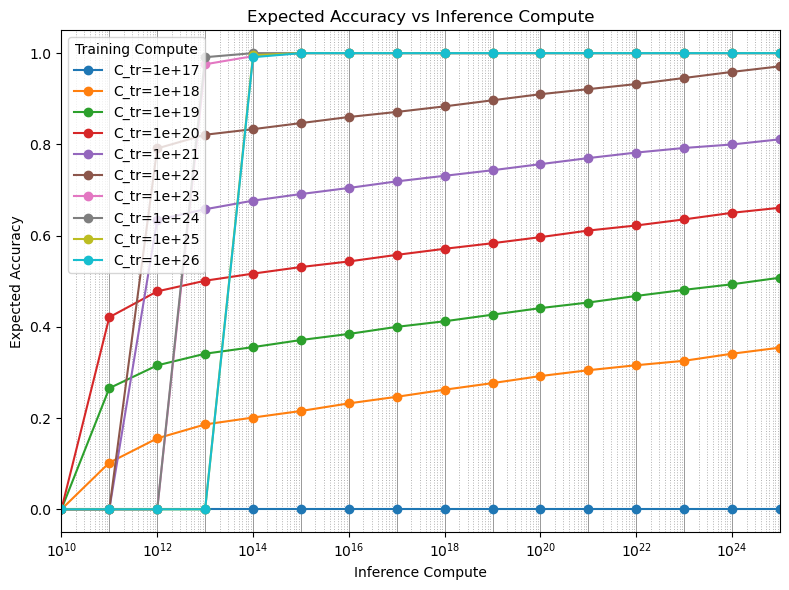

In [230]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Sort the dataframe
accuracy_df = accuracy_df.sort_values(["C_tr", "C_inf"])

# Plot each C_tr as a separate curve
for C_tr, group in accuracy_df.groupby("C_tr"):
    ax.plot(group["C_inf"], group["Accuracy"], marker='o', label=f'C_tr={C_tr}')

# Add legend
ax.legend(title="Training Compute")

# Set log scale
ax.set_xscale('log')

# Labels
ax.set_xlabel("Inference Compute")
ax.set_ylabel("Expected Accuracy")
ax.set_title("Expected Accuracy vs Inference Compute")

# Get data range
min_x = accuracy_df["C_inf"].min()
max_x = accuracy_df["C_inf"].max()

# Expand the x limits slightly to ensure visibility
log_min = np.floor(np.log10(min_x))
log_max = np.ceil(np.log10(max_x))
ax.set_xlim(10**log_min, 10**log_max)

# Force grid to be behind the data
ax.set_axisbelow(True)

# COMPLETELY DIFFERENT APPROACH TO GRID LINES:
# 1. First clear any automatic grid
ax.grid(False)

# 2. Manually draw major grid lines at powers of 10
major_ticks = [10**i for i in range(int(log_min), int(log_max)+1)]
for tick in major_ticks:
    ax.axvline(x=tick, color='black', linestyle='-', linewidth=0.7, alpha=0.4, zorder=0)

# 3. Manually draw minor grid lines
for decade in range(int(log_min), int(log_max)+1):
    for i in [2, 3, 4, 5, 6, 7, 8, 9]:
        ax.axvline(x=i*10**decade, color='gray', linestyle=':', linewidth=0.7, alpha=0.6, zorder=0)

# Configure major ticks (powers of 10)
ax.xaxis.set_major_locator(ticker.LogLocator(base=10))

# Configure minor ticks in between powers of 10
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2,3,4,5,6,7,8,9]))

# Optionally remove labels from minor ticks
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.show()

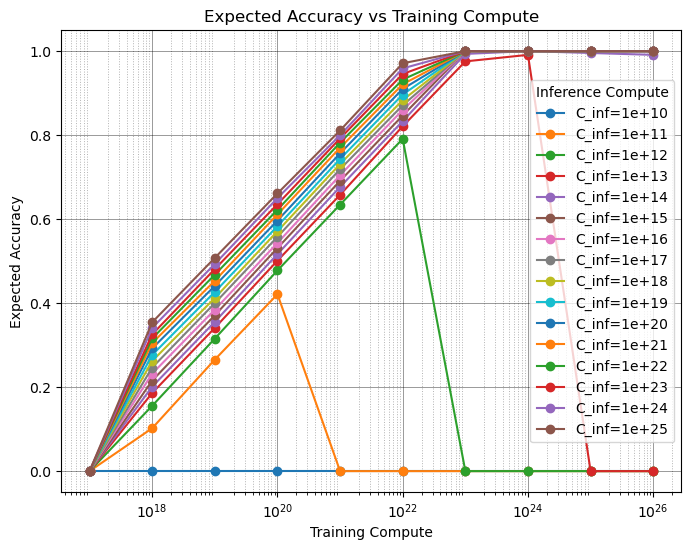

In [228]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Sort the dataframe by C_inf
accuracy_df = accuracy_df.sort_values(["C_inf", "C_tr"])

# Plot each C_tr as a separate curve and label by C_inf with scientific notation
for C_inf, group in accuracy_df.groupby("C_inf"):
    ax.plot(group["C_tr"], group["Accuracy"], marker='o', label=f'C_inf={C_inf:.0e}')

# Add legend
ax.legend(title="Inference Compute")

# Set log scale
ax.set_xscale('log')

# Labels
ax.set_xlabel("Training Compute")
ax.set_ylabel("Expected Accuracy")
ax.set_title("Expected Accuracy vs Training Compute")

# Force grid to be behind the data
ax.set_axisbelow(True)

# Enable major and minor grid
ax.grid(True, which='major', color='black', linestyle='-', linewidth=0.7, alpha=0.4)
ax.grid(True, which='minor', color='gray', linestyle=':', linewidth=0.7, alpha=0.6)

# Configure major ticks (powers of 10)
ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
# Configure minor ticks in between powers of 10 (2,3,4,5,6,7,8,9)
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2,3,4,5,6,7,8,9], numticks=12))
# Optionally remove labels from minor ticks
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.show()

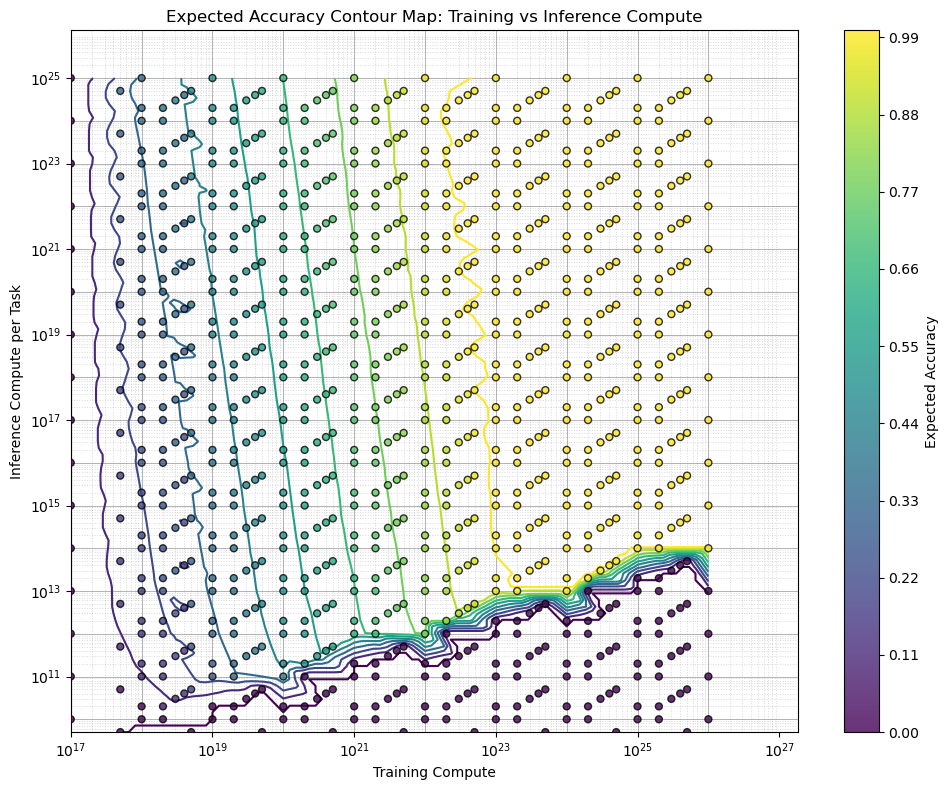

In [296]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data from dataframe
C_tr_values = accuracy_df['C_tr'].values
C_inf_values = accuracy_df['C_inf'].values
accuracy_values = accuracy_df['Accuracy'].values

# Create a regular grid for interpolation in log space
log_tr_min, log_tr_max = np.log10(C_tr_values.min()), np.log10(C_tr_values.max())
log_inf_min, log_inf_max = np.log10(C_inf_values.min()), np.log10(C_inf_values.max())

grid_size = 100
log_tr_grid = np.linspace(log_tr_min, log_tr_max, grid_size)
log_inf_grid = np.linspace(log_inf_min, log_inf_max, grid_size)
log_tr_mesh, log_inf_mesh = np.meshgrid(log_tr_grid, log_inf_grid)

# Points need to be in log space for better interpolation
log_points = np.column_stack((np.log10(C_tr_values), np.log10(C_inf_values)))

# Interpolate accuracy values onto the log grid
grid_accuracy = griddata(log_points, accuracy_values, (log_tr_mesh, log_inf_mesh), method='linear')

# Convert mesh back to linear scale for plotting
tr_mesh = 10**log_tr_mesh
inf_mesh = 10**log_inf_mesh

# Create contour levels excluding values above 0.99
min_acc = max(0, accuracy_values.min())
max_acc = min(0.99, accuracy_values.max())  # Cap at 0.99
levels = np.linspace(min_acc, max_acc, 10)

# Define colormap for consistency
cmap = plt.cm.viridis

# Create colored contour lines using the same colormap as scatter
# NO LABELS on the contours
contour_lines = ax.contour(tr_mesh, inf_mesh, grid_accuracy, levels=levels, 
                          cmap=cmap, linewidths=1.5)

# Add scatter points for actual data points
scatter = ax.scatter(C_tr_values, C_inf_values, c=accuracy_values, cmap=cmap,
                    edgecolor='k', s=25, alpha=0.8, zorder=5)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Expected Accuracy')

# Add tick marks to the colorbar to show contour levels
cbar.ax.set_yticks(levels)
cbar.ax.set_yticklabels([f'{level:.2f}' for level in levels])

# Set log scales
ax.set_xscale('log')
ax.set_yscale('log')

# Set the limit on C_inf
#ax.set_ylim(1e10, 1e14)

# Set axis labels and title
ax.set_xlabel('Training Compute')
ax.set_ylabel('Inference Compute per Task')
ax.set_title('Expected Accuracy Contour Map: Training vs Inference Compute')

# Manually draw grid lines
ax.grid(False)

# X-axis major grid lines
for decade in range(int(log_tr_min), int(log_tr_max)+1):
    ax.axvline(x=10**decade, color='black', linestyle='-', linewidth=0.7, alpha=0.3, zorder=0)

# Y-axis major grid lines
for decade in range(int(log_inf_min), int(log_inf_max)+1):
    ax.axhline(y=10**decade, color='black', linestyle='-', linewidth=0.7, alpha=0.3, zorder=0)

# X-axis minor grid lines
for decade in range(int(log_tr_min), int(log_tr_max)+1):
    for i in [2, 3, 4, 5, 6, 7, 8, 9]:
        ax.axvline(x=i*10**decade, color='gray', linestyle=':', linewidth=0.7, alpha=0.3, zorder=0)

# Y-axis minor grid lines
for decade in range(int(log_inf_min), int(log_inf_max)+1):
    for i in [2, 3, 4, 5, 6, 7, 8, 9]:
        ax.axhline(y=i*10**decade, color='gray', linestyle=':', linewidth=0.7, alpha=0.3, zorder=0)

# Configure axis ticks
ax.xaxis.set_major_locator(ticker.LogLocator(base=10))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10))
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2,3,4,5,6,7,8,9]))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2,3,4,5,6,7,8,9]))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.show()

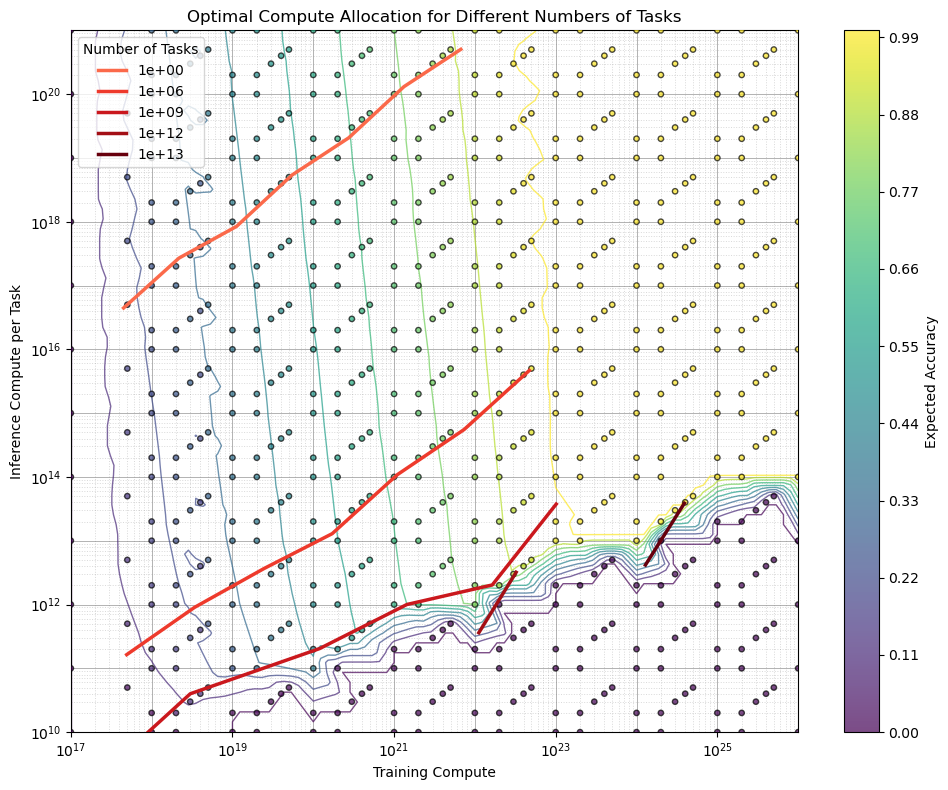

In [297]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data from dataframe
C_tr_values = accuracy_df['C_tr'].values
C_inf_values = accuracy_df['C_inf'].values
accuracy_values = accuracy_df['Accuracy'].values

# Create a regular grid for interpolation in log space
log_tr_min, log_tr_max = np.log10(C_tr_values.min()), np.log10(C_tr_values.max())
log_inf_min, log_inf_max = np.log10(C_inf_values.min()), np.log10(C_inf_values.max())

grid_size = 100
log_tr_grid = np.linspace(log_tr_min, log_tr_max, grid_size)
log_inf_grid = np.linspace(log_inf_min, log_inf_max, grid_size)
log_tr_mesh, log_inf_mesh = np.meshgrid(log_tr_grid, log_inf_grid)

# Points need to be in log space for better interpolation
log_points = np.column_stack((np.log10(C_tr_values), np.log10(C_inf_values)))

# Interpolate accuracy values onto the log grid
grid_accuracy = griddata(log_points, accuracy_values, (log_tr_mesh, log_inf_mesh), method='linear')

# Convert mesh back to linear scale for plotting
tr_mesh = 10**log_tr_mesh
inf_mesh = 10**log_inf_mesh

# Create contour levels excluding values above 0.99
min_acc = max(0, accuracy_values.min())
max_acc = min(0.99, accuracy_values.max())  # Cap at 0.99
levels = np.linspace(min_acc, max_acc, 10)

# Define colormap for consistency
cmap = plt.cm.viridis

# Create colored contour lines with increased transparency
contour_lines = ax.contour(tr_mesh, inf_mesh, grid_accuracy, levels=levels, 
                          cmap=cmap, linewidths=1.0, alpha=0.7)  # More transparent

# Add scatter points with increased transparency
scatter = ax.scatter(C_tr_values, C_inf_values, c=accuracy_values, cmap=cmap,
                    edgecolor='k', s=15, alpha=0.7, zorder=5)  # Smaller and more transparent

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Expected Accuracy')
cbar.ax.set_yticks(levels)
cbar.ax.set_yticklabels([f'{level:.2f}' for level in levels])

# Create an interpolator for accuracy as a function of C_tr and C_inf
accuracy_interp = LinearNDInterpolator(log_points, accuracy_values)

# Define the range of inference counts
inference_counts = [1, 1e6, 1e9, 1e12, 1e13]

# Create a red colormap with progressively darker shades
# Use a reversed "Reds" colormap so larger values of I get darker shades
red_cmap = cm.get_cmap('Reds')
optimal_curve_colors = red_cmap(np.linspace(0.5, 1, len(inference_counts)))

# For each inference count, find the optimal compute allocation
for i, I in enumerate(inference_counts):
    # Create a range of total compute values to explore
    C_tot_values = np.logspace(log_tr_min, log_tr_max + np.log10(I*10**log_inf_max), 50)
    
    optimal_tr = []
    optimal_inf = []
    optimal_acc = []
    
    for C_tot in C_tot_values:
        best_acc = 0
        best_tr = 0
        best_inf = 0
        
        # Sample different allocations of compute to find optimal
        for ratio in np.linspace(0.01, 0.99, 50):
            C_tr_test = C_tot * ratio
            C_inf_test = (C_tot - C_tr_test) / I
            
            # Skip if C_inf is too small (below minimum in dataset)
            if C_inf_test < 10**log_inf_min:
                continue
                
            # Skip if C_tr is too small (below minimum in dataset)
            if C_tr_test < 10**log_tr_min:
                continue
                
            # Skip if values exceed our data range
            if np.log10(C_tr_test) > log_tr_max or np.log10(C_inf_test) > log_inf_max:
                continue
            
            # Get predicted accuracy
            acc = accuracy_interp(np.log10(C_tr_test), np.log10(C_inf_test))
            
            # Update if this is better
            if not np.isnan(acc) and acc > best_acc:
                best_acc = acc
                best_tr = C_tr_test
                best_inf = C_inf_test
        
        # Only add if accuracy is below 0.99 and we found a valid solution
        if best_acc > 0 and best_acc < .99:
            optimal_tr.append(best_tr)
            optimal_inf.append(best_inf)
            optimal_acc.append(best_acc)
    
    # Plot the optimal curve with thicker lines to stand out
    if optimal_tr:  # Only if we have valid points
        ax.plot(optimal_tr, optimal_inf, '-', color=optimal_curve_colors[i], 
                linewidth=2.5, label=f'{I:.0e}', zorder=10)

# Set log scales
ax.set_xscale('log')
ax.set_yscale('log')

# Dont go above 1e21 on the y-axis
ax.set_ylim(1e10, 1e21)
ax.set_xlim(1e17, 1e26)

# Set axis labels and title
ax.set_xlabel('Training Compute')
ax.set_ylabel('Inference Compute per Task')
ax.set_title('Optimal Compute Allocation for Different Numbers of Tasks')

# Add legend for inference counts
ax.legend(title='Number of Tasks', loc='best')

# Manually draw grid lines with increased transparency
ax.grid(False)

# X-axis major grid lines
for decade in range(int(log_tr_min), int(log_tr_max)+1):
    ax.axvline(x=10**decade, color='black', linestyle='-', linewidth=0.7, alpha=0.3, zorder=0)

# Y-axis major grid lines
for decade in range(int(log_inf_min), int(log_inf_max)+1):
    ax.axhline(y=10**decade, color='black', linestyle='-', linewidth=0.7, alpha=0.3, zorder=0)

# X-axis minor grid lines
for decade in range(int(log_tr_min), int(log_tr_max)+1):
    for i in [2, 3, 4, 5, 6, 7, 8, 9]:
        ax.axvline(x=i*10**decade, color='gray', linestyle=':', linewidth=0.7, alpha=0.3, zorder=0)

# Y-axis minor grid lines
for decade in range(int(log_inf_min), int(log_inf_max)+1):
    for i in [2, 3, 4, 5, 6, 7, 8, 9]:
        ax.axhline(y=i*10**decade, color='gray', linestyle=':', linewidth=0.7, alpha=0.3, zorder=0)

# Configure axis ticks
ax.xaxis.set_major_locator(ticker.LogLocator(base=10))
ax.yaxis.set_major_locator(ticker.LogLocator(base=10))
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2,3,4,5,6,7,8,9]))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=[2,3,4,5,6,7,8,9]))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.show()

In [ ]:
# Given C_tot 1e24, let C_tr = 
# Define a smaller set of tasks with non-zero probability for efficiency
def get_valid_tasks():
    valid_tasks = []
    for l in range(1, L+1):
        for m in range(2, 11):
            if q(l, m) > 0:
                valid_tasks.append((l, m, q(l, m)))
    return valid_tasks

valid_tasks = get_valid_tasks()

Number of valid tasks: 900
Processing C_tot = 1.00e+16
Processing C_tot = 1.00e+18
Processing C_tot = 1.00e+20
Processing C_tot = 1.00e+22
Processing C_tot = 1.00e+24

Results:
C_tot: 1.00e+16, C_tr: 1.00e+16, C_inf: 1.00e+08, C_inf/C_tr: 0.0000, Accuracy: 0.0000
C_tot: 1.00e+18, C_tr: 1.00e+18, C_inf: 1.00e+09, C_inf/C_tr: 0.0000, Accuracy: 0.0000
C_tot: 1.00e+20, C_tr: 1.00e+20, C_inf: 1.00e+10, C_inf/C_tr: 0.0000, Accuracy: 0.0000
C_tot: 1.00e+22, C_tr: 1.00e+22, C_inf: 1.00e+11, C_inf/C_tr: 0.0000, Accuracy: 0.0000
C_tot: 1.00e+24, C_tr: 1.00e+24, C_inf: 1.00e+12, C_inf/C_tr: 0.0000, Accuracy: 0.0000


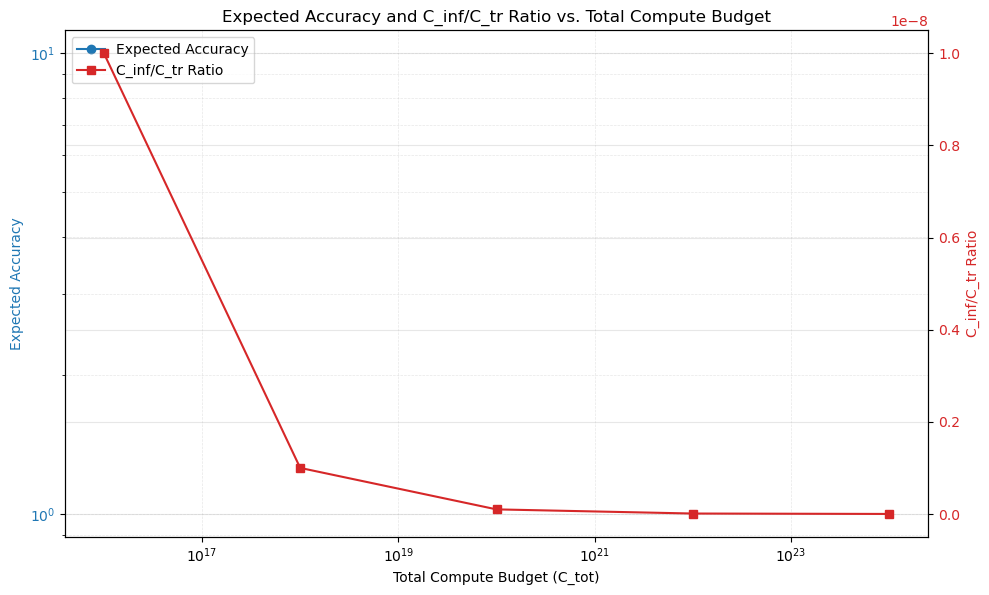

In [142]:
# Define a smaller set of tasks with non-zero probability for efficiency
def get_valid_tasks():
    valid_tasks = []
    for l in range(1, L+1):
        for m in range(2, 11):
            if q(l, m) > 0:
                valid_tasks.append((l, m, q(l, m)))
    return valid_tasks

valid_tasks = get_valid_tasks()
print(f"Number of valid tasks: {len(valid_tasks)}")

# Function to compute C_inf and C_tr with the given formula
def compute_costs(C_tot):
    """Compute C_inf and C_tr based on the formula C_inf = sqrt(C_tr)."""
    C_inf = 0.5 * (np.sqrt(4 * C_tot + 1) - 1)
    C_tr = C_inf**2
    return C_tr, C_inf

# Define function to compute expected accuracy for a given C_tot
def compute_expected_accuracy(C_tot):
    """Compute expected accuracy for a given C_tot using the formula allocation."""
    C_tr, C_inf = compute_costs(C_tot)
    
    expected_accuracy = 0
    total_probability = 0
    
    for l, m, task_prob in valid_tasks:
        accuracy = evaluate_allocation(C_tr, C_inf, l, m)
        expected_accuracy += task_prob * accuracy
        total_probability += task_prob
    
    if total_probability > 0:
        expected_accuracy /= total_probability
    
    ratio = C_inf / C_tr
    return C_tot, C_tr, C_inf, ratio, expected_accuracy

# Use larger C_tot values as suggested
C_tot_values = [1e16, 1e18, 1e20, 1e22, 1e24]

# Compute results for each C_tot
results = []
for C_tot in C_tot_values:
    print(f"Processing C_tot = {C_tot:.2e}")
    result = compute_expected_accuracy(C_tot)
    results.append(result)

# Print results
print("\nResults:")
for r in results:
    C_tot, C_tr, C_inf, ratio, accuracy = r
    print(f"C_tot: {C_tot:.2e}, C_tr: {C_tr:.2e}, C_inf: {C_inf:.2e}, C_inf/C_tr: {ratio:.4f}, Accuracy: {accuracy:.4f}")

# Prepare data for plotting
C_tot_values = [r[0] for r in results]
ratios = [r[3] for r in results]
accuracies = [r[4] for r in results]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
color = 'tab:blue'
ax1.set_xlabel('Total Compute Budget (C_tot)')
ax1.set_ylabel('Expected Accuracy', color=color)
ax1.loglog(C_tot_values, accuracies, 'o-', color=color, label='Expected Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot ratio
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('C_inf/C_tr Ratio', color=color)
ax2.semilogx(C_tot_values, ratios, 's-', color=color, label='C_inf/C_tr Ratio')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.title('Expected Accuracy and C_inf/C_tr Ratio vs. Total Compute Budget')
plt.savefig('compute_allocation_large_scale.png')
plt.show()